# Generate inclusion burden map for a sample slide

In [1]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import json
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide
from scipy.ndimage import gaussian_filter

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.10.1+cu111
Torchvision Version:  0.11.2
CUDA status:  True
CUDA memory max alloc:        0 MB


/usr/lib/python3/dist-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


## Experiment Setup

In [15]:
# Set the experiment directory
exp_dir = "/home/pauly2/cndr_histo/data/phf1/samples/exp03"

# Set the WSI file to process
wsi_file = "/home/pauly2/cndr_histo/scratch2/2013-223-15F_L_HIP_AT8_1K_02-01-21_WT.svs"
# wsi_file = "/home/pauly2/cndr_histo/scratch2/mrxs/2021-209 hipp phf1.mrxs"

# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 224

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 2240

## Load Configuration and Models

In [16]:
# Set main directories
data_dir = os.path.join(exp_dir, "patches")
model_dir = os.path.join(exp_dir, "models")

# Load model configuration from config.json
with open(os.path.join(model_dir, 'config.json'), 'r') as jfile:
    config = json.load(jfile)

# Set global properties
num_classes=config['num_classes']
input_size=config['wildcat_upsample']['input_size']
batch_size=config['wildcat_upsample']['batch_size']

In [17]:
# Create the model
model_ft=resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Read model state
model_ft.load_state_dict(
    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


## Load WSI

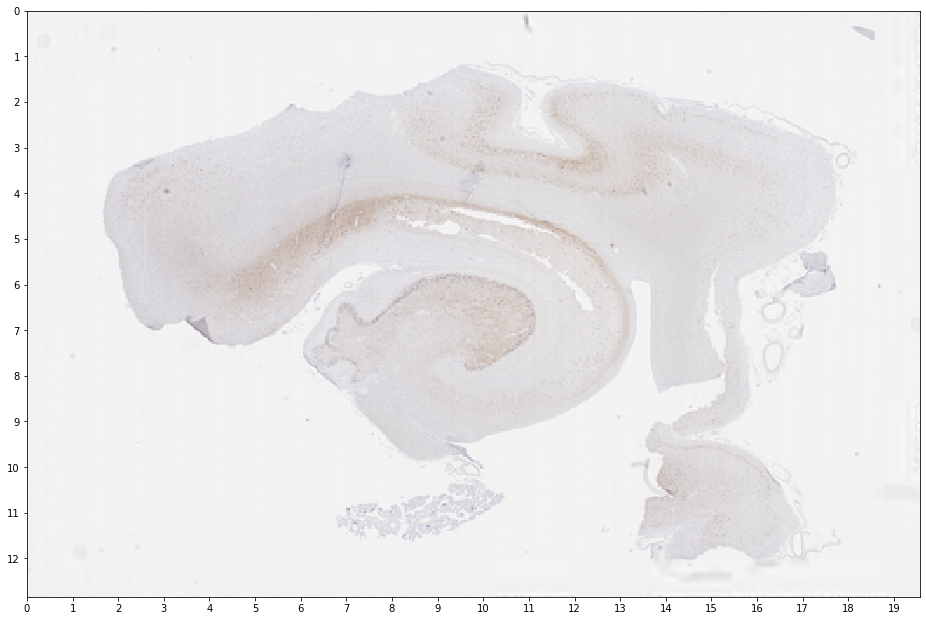

In [18]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide(wsi_file)
plt.figure(figsize=(16,16))
plt.imshow(osl.get_thumbnail((512,512)), 
           extent=(0,osl.level_dimensions[0][0]/window_size_raw,osl.level_dimensions[0][1]/window_size_raw,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/window_size_raw));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/window_size_raw));

## Generate burden map
To speed this up, you can specify a sub-range of pixels to process

In [19]:
# u_range,v_range = None,None
u_range,v_range = (6,14),(4,9)
# u_range,v_range = (18,23),(38,43)

In [20]:
# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
padding_size_rel = 1.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=2

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=4

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((num_classes, out_dim[0], out_dim[1]))

# Range of pixels to scan
u_range = (0,n_win[0]) if u_range is None else u_range
v_range = (0,n_win[1]) if v_range is None else v_range

# Range non-overlapping windows
t_00 = timeit.default_timer()
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp,wp = x-padding_size_raw,y-padding_size_raw,window_size_raw+2*padding_size_raw
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")
        t1 = timeit.default_timer()
                
        # Compute the desired size of input to wildcat
        wwc = int(wp * input_size / patch_size_raw)

        # Resample the chunk for the two networks
        tran = transforms.Compose([
            transforms.Resize((wwc,wwc)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Convert the read chunk to tensor format
        with torch.no_grad():
            
            # Apply transforms and turn into correct-size torch tensor
            chunk_tensor=torch.unsqueeze(tran(chunk_img),dim=0).to(device)
            
            # Forward pass through the wildcat model
            x_clas = model_ft.forward_to_classifier(chunk_tensor)
            x_cpool = model_ft.spatial_pooling.class_wise(x_clas)

            # Scale the cpool image to desired size
            x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

            # Extract the central portion of the output
            p0,p1 = padding_size_out,(padding_size_out+window_size_out)
            x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]
            
            # Stick it into the output array
            xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
            yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
            for i in range(num_classes):
                density[i,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,i,:,:].transpose()
                
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

# Take the softmax of the density along the zero dimension
density_softmax=scipy.special.softmax(density, axis=0)

Chunk: (     6,     4) Times: IO=0.9498 WldC=0.5093 Totl=  1.4592
Chunk: (     6,     5) Times: IO=0.9532 WldC=0.5058 Totl=  1.4591
Chunk: (     6,     6) Times: IO=0.9548 WldC=0.5057 Totl=  1.4605
Chunk: (     6,     7) Times: IO=0.9604 WldC=0.5157 Totl=  1.4761
Chunk: (     6,     8) Times: IO=0.9313 WldC=0.5146 Totl=  1.4459
Chunk: (     7,     4) Times: IO=0.9615 WldC=0.5205 Totl=  1.4820
Chunk: (     7,     5) Times: IO=0.9684 WldC=0.5139 Totl=  1.4823
Chunk: (     7,     6) Times: IO=0.9590 WldC=0.5159 Totl=  1.4750
Chunk: (     7,     7) Times: IO=0.9614 WldC=0.5174 Totl=  1.4788
Chunk: (     7,     8) Times: IO=0.9491 WldC=0.5134 Totl=  1.4625
Chunk: (     8,     4) Times: IO=0.9603 WldC=0.5119 Totl=  1.4723
Chunk: (     8,     5) Times: IO=0.9605 WldC=0.5109 Totl=  1.4714
Chunk: (     8,     6) Times: IO=0.9568 WldC=0.5155 Totl=  1.4723
Chunk: (     8,     7) Times: IO=0.9581 WldC=0.5150 Totl=  1.4731
Chunk: (     8,     8) Times: IO=0.9535 WldC=0.5149 Totl=  1.4684
Chunk: (  

In [21]:
# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,fg_class=1,vrange=(0, 1),sigma=0,show_ticks=True):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    # t_map=(2 * density[fg_class,o_u0:o_u1,o_v0:o_v1] - density[:,o_u0:o_u1,o_v0:o_v1].sum(axis=0)).transpose()
    # density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    # t_map=np.where(t_map > 0, t_map, 0)
    t_map=density_softmax[fg_class, o_u0:o_u1,o_v0:o_v1].transpose()
    t_map=np.where(t_map > 1.0/num_classes, t_map, 1.0/num_classes)
    
    # Smooth the tangle map
    t_map = gaussian_filter(t_map, sigma)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[0].set_title('Image Patch')
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    label = list(config['class_to_idx'].keys())[list(config['class_to_idx'].values()).index(fg_class)]
    ax[1].set_title('Class %s Density Softmax' % (label,))
    # ax[1].colorbar(cs)
    if show_ticks is False:
        ax[0].xaxis.set_ticklabels([])
        ax[1].xaxis.set_ticklabels([])
        ax[0].yaxis.set_ticklabels([])
        ax[1].yaxis.set_ticklabels([])
    fig.show()

# Visualize burden map

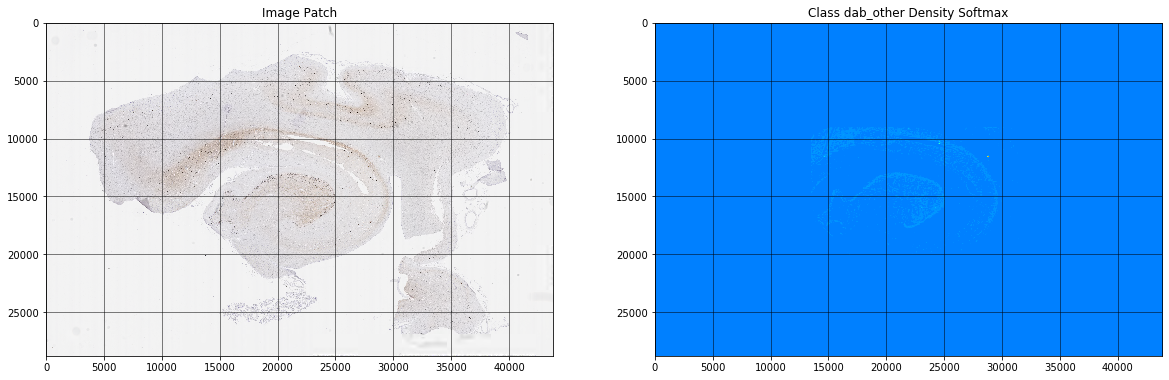

In [24]:
# plot_classification_region(7500,5000,42500,40000,2,(-3,3),10, show_ticks=True)
plot_classification_region(0,0,slide_dim[0],slide_dim[1],2,fg_class=1,sigma=2)
# plot_classification_region(u_range[0]*window_size_raw,v_range[0]*window_size_raw,u_range[1]*window_size_raw,v_range[1]*window_size_raw,6,
#                           fg_class=3,sigma=2)

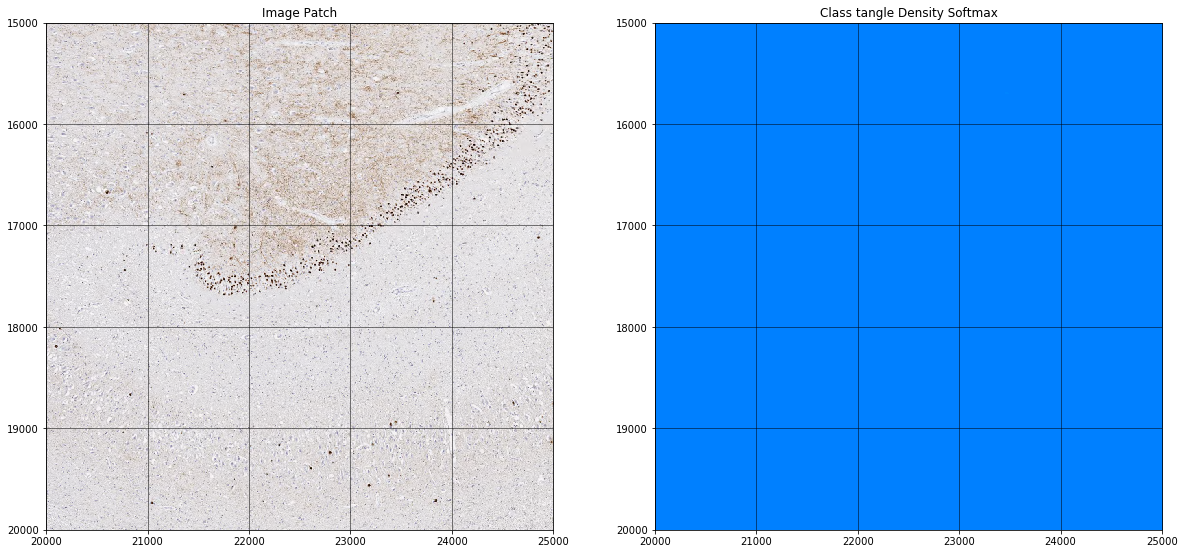

In [29]:
plot_classification_region(20000,15000,25000,20000,1,fg_class=3,sigma=2,show_ticks=True)
# plot_classification_region(40000,86000,42000,88000,0,fg_class=3,sigma=2,show_ticks=True)

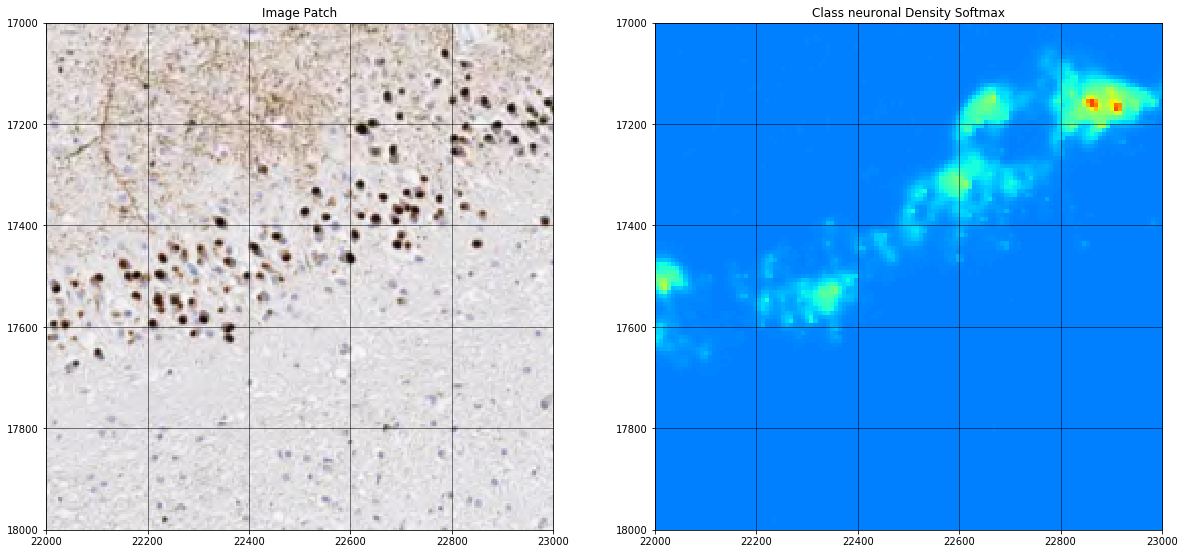

In [215]:
plot_classification_region(22000,17000,23000,18000,1,fg_class=1,sigma=0.4,show_ticks=True)

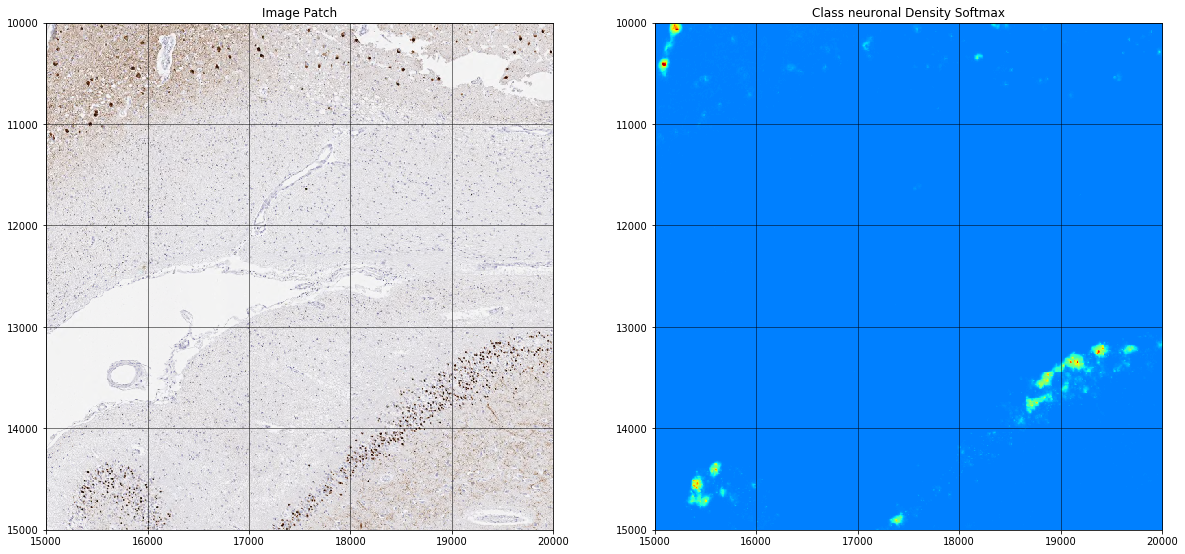

In [216]:
plot_classification_region(15000,10000,20000,15000,1,fg_class=1,sigma=0.2,show_ticks=True)

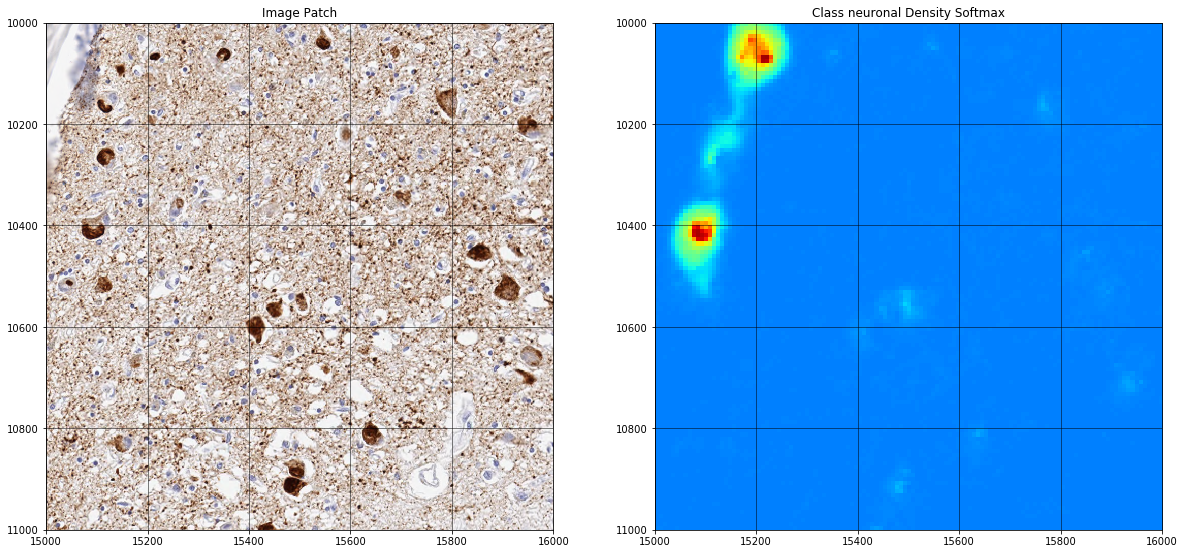

In [217]:
plot_classification_region(15000,10000,16000,11000,0,fg_class=1,sigma=0.2,show_ticks=True)